In [1]:
import sys
sys.path.append("../src")

from utils.load_model import get_model

from my_model import get_ilsvrc2012

from torch.utils.data import DataLoader

from utils.imagenet1000_classname import imgnet_label_name
from utils.tensortracker import TensorTracker
from utils import plots

In [2]:
%matplotlib inline

In [3]:
import os

import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

import torch.nn as nn

import svcca

In [4]:
from my_model import my_resnet

from glob import glob

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [5]:
from utils.receptive_field_tracker import RFTracker

In [6]:
plain_model = my_resnet.resnet34(pretrained=False, plain=True)
skip_model = my_resnet.resnet34(pretrained=False, plain=False)

In [7]:
root = "/data2/genta/resnet"

In [8]:
plain_paths = sorted(glob(os.path.join(root, '20200814*plain*', '*.model')))[:-2]
plain_paths = sorted(glob(os.path.join(root, '20200814*plain*', 'init.model'))) + plain_paths

# plain_paths = sorted(glob(os.path.join(root, '20200821*plain*', '*.model')))[:-2]
# plain_paths = sorted(glob(os.path.join(root, '20200821*plain*', 'init.model'))) + plain_paths

skip_paths = sorted(glob(os.path.join(root, '20200814*resnet*', '*.model')))[:-2]
skip_paths = sorted(glob(os.path.join(root, '20200814*resnet*', 'init.model'))) + skip_paths

# skip_paths = sorted(glob(os.path.join(root, '20200821*resnet*', '*.model')))[:-2]
# skip_paths = sorted(glob(os.path.join(root, '20200821*resnet*', 'init.model'))) + skip_paths

In [9]:
mode = "test"
test_dataset = get_ilsvrc2012(mode=mode, transform_type="test")
test_labels = np.asarray(test_dataset.targets)

index = []
for i in range(1000):
    idx = np.where(test_labels == i)[0][0]
    index.append(idx)
index = np.asarray(index)

device = "cuda"
N = 256
np.random.seed(815)
perm = np.random.permutation(len(index))
images = [test_dataset[i][0] for i in index[perm[:N]]]
images = torch.stack(images)
images = images.to(device)

In [10]:
skip_model = skip_model.to(device)
skip_model.eval()

rf_tracker = RFTracker(skip_model)
out = skip_model(images)

In [11]:
for key in rf_tracker.rf_pool:
    print(rf_tracker.find_receptive_field(key), key)

(112, 2, 7, 1.5) conv1
(112, 2, 7, 1.5) bn1
(112, 2, 7, 1.5) relu
(56, 4, 11, 3.5) maxpool
(56, 4, 19, 3.5) layer1.0.conv1
(56, 4, 19, 3.5) layer1.0.bn1
(56, 4, 19, 3.5) layer1.0.relu1
(56, 4, 27, 3.5) layer1.0.conv2
(56, 4, 27, 3.5) layer1.0.bn2
(56, 4, 27, 3.5) layer1.0.add_func
(56, 4, 27, 3.5) layer1.0.relu2
(56, 4, 35, 3.5) layer1.1.conv1
(56, 4, 35, 3.5) layer1.1.bn1
(56, 4, 35, 3.5) layer1.1.relu1
(56, 4, 43, 3.5) layer1.1.conv2
(56, 4, 43, 3.5) layer1.1.bn2
(56, 4, 43, 3.5) layer1.1.add_func
(56, 4, 43, 3.5) layer1.1.relu2
(56, 4, 51, 3.5) layer1.2.conv1
(56, 4, 51, 3.5) layer1.2.bn1
(56, 4, 51, 3.5) layer1.2.relu1
(56, 4, 59, 3.5) layer1.2.conv2
(56, 4, 59, 3.5) layer1.2.bn2
(56, 4, 59, 3.5) layer1.2.add_func
(56, 4, 59, 3.5) layer1.2.relu2
(28, 8, 67, 7.5) layer2.0.conv1
(28, 8, 67, 7.5) layer2.0.bn1
(28, 8, 67, 7.5) layer2.0.relu1
(28, 8, 83, 7.5) layer2.0.conv2
(28, 8, 83, 7.5) layer2.0.bn2
(28, 8, 59, 7.5) layer2.0.downsample.0
(28, 8, 59, 7.5) layer2.0.downsample.1
(28, 8

In [12]:
for name, m in skip_model.named_modules():
    if isinstance(m, (nn.Sequential, )):
        print(name, type(m))

layer1 <class 'src.my_model.blocks.MySequential'>
layer1.0 <class 'src.my_model.blocks.BasicBlock'>
layer1.1 <class 'src.my_model.blocks.BasicBlock'>
layer1.2 <class 'src.my_model.blocks.BasicBlock'>
layer2 <class 'src.my_model.blocks.MySequential'>
layer2.0 <class 'src.my_model.blocks.BasicBlock'>
layer2.0.downsample <class 'src.my_model.blocks.MySequential'>
layer2.1 <class 'src.my_model.blocks.BasicBlock'>
layer2.2 <class 'src.my_model.blocks.BasicBlock'>
layer2.3 <class 'src.my_model.blocks.BasicBlock'>
layer3 <class 'src.my_model.blocks.MySequential'>
layer3.0 <class 'src.my_model.blocks.BasicBlock'>
layer3.0.downsample <class 'src.my_model.blocks.MySequential'>
layer3.1 <class 'src.my_model.blocks.BasicBlock'>
layer3.2 <class 'src.my_model.blocks.BasicBlock'>
layer3.3 <class 'src.my_model.blocks.BasicBlock'>
layer3.4 <class 'src.my_model.blocks.BasicBlock'>
layer3.5 <class 'src.my_model.blocks.BasicBlock'>
layer4 <class 'src.my_model.blocks.MySequential'>
layer4.0 <class 'src.my_

In [13]:
rf_tracker.remove_hook()

In [23]:
plain_model = plain_model.to(device)
plain_model.eval()
tracker = TensorTracker(plain_model)
plain_model(images[:2])
keys_skip = tracker.fmap_pool.keys()

In [24]:
keys = np.asarray(list(keys_skip))
target_key = [np.where(keys == k)[0][0] for k in keys if "relu" in k or "maxpool" == k]
# target_key = [np.where(keys == k)[0][0] for k in keys if "relu3" in k or "maxpool" == k]
cand_layers = keys[target_key].tolist()

In [25]:
cand_layers

['relu',
 'maxpool',
 'layer1.0.relu1',
 'layer1.0.relu2',
 'layer1.1.relu1',
 'layer1.1.relu2',
 'layer1.2.relu1',
 'layer1.2.relu2',
 'layer2.0.relu1',
 'layer2.0.relu2',
 'layer2.1.relu1',
 'layer2.1.relu2',
 'layer2.2.relu1',
 'layer2.2.relu2',
 'layer2.3.relu1',
 'layer2.3.relu2',
 'layer3.0.relu1',
 'layer3.0.relu2',
 'layer3.1.relu1',
 'layer3.1.relu2',
 'layer3.2.relu1',
 'layer3.2.relu2',
 'layer3.3.relu1',
 'layer3.3.relu2',
 'layer3.4.relu1',
 'layer3.4.relu2',
 'layer3.5.relu1',
 'layer3.5.relu2',
 'layer4.0.relu1',
 'layer4.0.relu2',
 'layer4.1.relu1',
 'layer4.1.relu2',
 'layer4.2.relu1',
 'layer4.2.relu2']

In [26]:
for l in cand_layers:
    print(l, rf_tracker.find_receptive_field(l))

relu (112, 2, 7, 1.5)
maxpool (56, 4, 11, 3.5)
layer1.0.relu1 (56, 4, 19, 3.5)
layer1.0.relu2 (56, 4, 27, 3.5)
layer1.1.relu1 (56, 4, 35, 3.5)
layer1.1.relu2 (56, 4, 43, 3.5)
layer1.2.relu1 (56, 4, 51, 3.5)
layer1.2.relu2 (56, 4, 59, 3.5)
layer2.0.relu1 (28, 8, 67, 7.5)
layer2.0.relu2 (28, 8, 83, 7.5)
layer2.1.relu1 (28, 8, 99, 7.5)
layer2.1.relu2 (28, 8, 115, 7.5)
layer2.2.relu1 (28, 8, 131, 7.5)
layer2.2.relu2 (28, 8, 147, 7.5)
layer2.3.relu1 (28, 8, 163, 7.5)
layer2.3.relu2 (28, 8, 179, 7.5)
layer3.0.relu1 (14, 16, 195, 15.5)
layer3.0.relu2 (14, 16, 227, 15.5)
layer3.1.relu1 (14, 16, 259, 15.5)
layer3.1.relu2 (14, 16, 291, 15.5)
layer3.2.relu1 (14, 16, 323, 15.5)
layer3.2.relu2 (14, 16, 355, 15.5)
layer3.3.relu1 (14, 16, 387, 15.5)
layer3.3.relu2 (14, 16, 419, 15.5)
layer3.4.relu1 (14, 16, 451, 15.5)
layer3.4.relu2 (14, 16, 483, 15.5)
layer3.5.relu1 (14, 16, 515, 15.5)
layer3.5.relu2 (14, 16, 547, 15.5)
layer4.0.relu1 (7, 32, 579, 31.5)
layer4.0.relu2 (7, 32, 643, 31.5)
layer4.1.rel

In [27]:
p_tracker = TensorTracker(plain_model, candidate_layers=cand_layers)
s_tracker = TensorTracker(skip_model, candidate_layers=cand_layers)

In [28]:
model = plain_model
paths = plain_paths[::10]
tracker = p_tracker

packs = [
    (plain_model, p_tracker, plain_paths[-1:]),
    (skip_model, s_tracker, skip_paths[-1:]),
]

data_list = []

for model, tracker, paths in packs:
    datas = []
    for path in tqdm(paths, total=len(paths)):
        name = os.path.basename(path)
        model.load_state_dict(my_resnet.fix_model_state_dict(torch.load(path)))
        model = model.eval()
        model = model.to(device)

        with torch.no_grad():
            out = model(images)
        data = []
        func = lambda x: (len(x) - np.count_nonzero(x)) / len(x)
        for l1 in keys[target_key]:
            act1 = tracker.find_fmap(l1).to('cpu').numpy()
            data.append(func(act1.reshape(-1)))
        data = np.asarray(data)
        datas.append(data)
    datas = np.asarray(datas)
    data_list.append(datas)

100%|██████████| 1/1 [00:02<00:00,  2.94s/it]


In [29]:
plain_datas = data_list[0].copy()
skip_datas = data_list[1].copy()

In [30]:
linestyles = [
    "solid",
    "dashed",
    "dotted"
]

In [31]:
# cmap = plt.get_cmap("viridis")
cmaps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis']
cmap = plt.get_cmap(cmaps[4])
colors = [cmap(i) for i in np.linspace(0, 1, len(datas))]
alpha = 0.7

In [32]:

def plot_helper(data, index=None):
    plt.figure(figsize=(14, 7))
    if index is None:
        index = np.arange(data.shape[1])
    for cnt, d in enumerate(data):
        x = np.arange(len(index))
        name = os.path.basename(paths[cnt])
        plt.plot(x, d[index], linestyle=linestyles[cnt % len(linestyles)], color=colors[cnt], alpha=alpha, label=name)

    plt.xticks(x, np.asarray(cand_layers)[index], rotation=90)
    plt.ylabel("sparse activation rate")
    plt.ylim(0, 1)
    plt.grid()
    plt.legend()
    plt.show()

plain


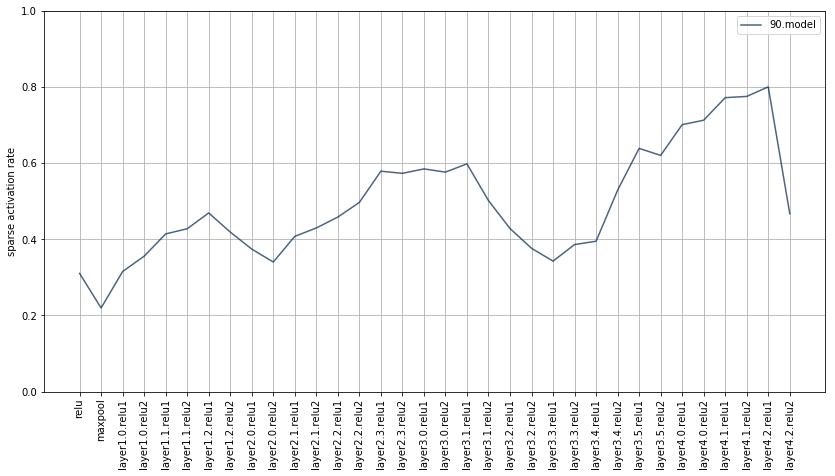

skip


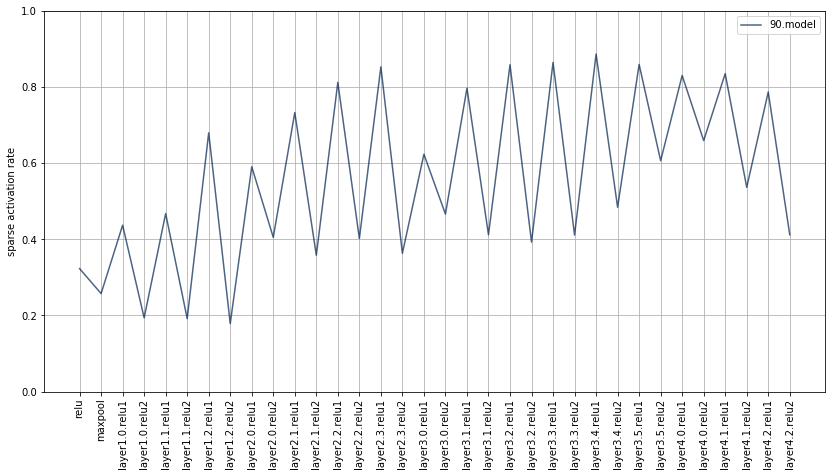

In [33]:
print("plain")
plot_helper(plain_datas)
print("skip")
plot_helper(skip_datas)

In [34]:
index = np.asarray([i for i, cl in enumerate(cand_layers) if "relu2" in cl])

plain


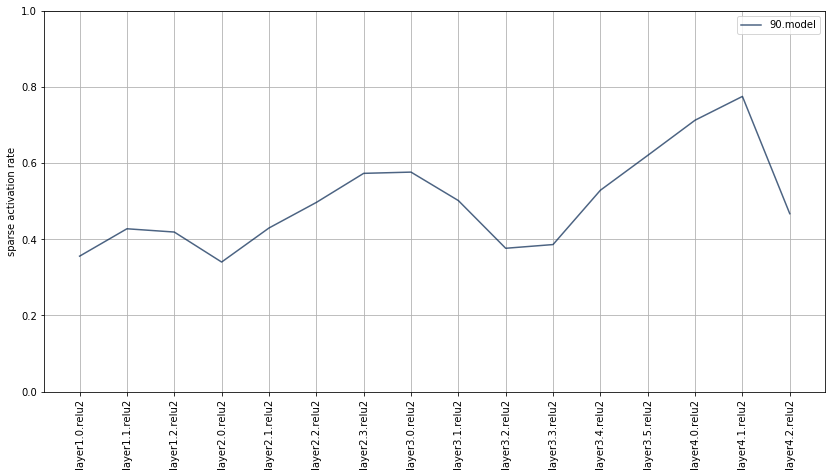

skip


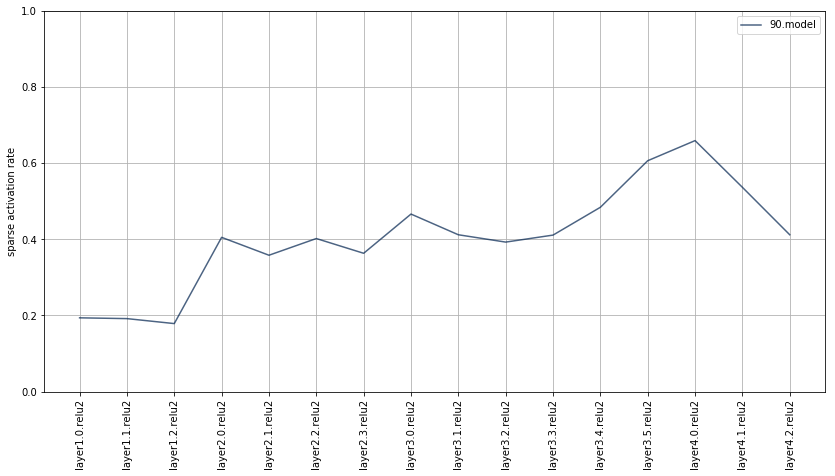

In [35]:
print("plain")
plot_helper(plain_datas, index)
print("skip")
plot_helper(skip_datas, index)

In [36]:
packs = [
    ("resnet34-skip", "resnet34-skip2", "resnet34-skip3",),
    ("resnet34-plain", "resnet34-plain2", "resnet34-plain3",)
]

data_list = []

for names in packs:
    datas = []
    for name in tqdm(names, total=len(names)):
        model = get_model(name)
        model = model.eval()
        model = model.to(device)
        tracker = TensorTracker(model, candidate_layers=cand_layers)
        with torch.no_grad():
            out = model(images)
        data = []
        func = lambda x: (len(x) - np.count_nonzero(x)) / len(x)
        for l1 in keys[target_key]:
            act1 = tracker.find_fmap(l1).to('cpu').numpy()
            data.append(func(act1.reshape(-1)))
        data = np.asarray(data)
        datas.append(data)
        tracker.remove()
    datas = np.asarray(datas)
    data_list.append(datas)

100%|██████████| 3/3 [00:09<00:00,  3.09s/it]


In [37]:
plain_datas = data_list[1].copy()
skip_datas = data_list[0].copy()

In [57]:
# cmap = plt.get_cmap("viridis")
cmaps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis']
cmap = plt.get_cmap(cmaps[4])
colors = [cmap(i) for i in np.linspace(0, 1, len(datas))]
alpha = 0.7

def plot_helper(data, index=None, labels=None, colors=None, fillx=None):
    plt.figure(figsize=(14, 7))
    if index is None:
        index = np.arange(data.shape[1])
    if fillx is not None:
        assert hasattr(fillx, "__iter__")
        _cmap = plt.get_cmap("rainbow")
        _colors = [_cmap(i) for i in np.linspace(0, 1, len(fillx))]
        for cnt, x in enumerate(fillx):
            color = _colors[cnt]
            plt.fill_between(x, 0, 1, color=color, alpha=0.1)

    for cnt, d in enumerate(data):
        x = np.arange(len(index))
        if labels is None:
            name = ""
        else:
            name = labels[cnt]
        if colors is None:
            color = "k"
        else:
            color = colors[cnt]
            
        plt.plot(x, d[index], linestyle=linestyles[cnt % len(linestyles)], color=color, alpha=alpha, label=name)

    plt.xticks(x, np.asarray(cand_layers)[index], rotation=90)
    plt.ylabel("sparse activation rate")
    plt.ylim(0, 1)
    plt.grid()
    plt.legend()
    plt.show()

In [58]:
fill_sepkeys = [
    "layer1",
    "layer2",
    "layer3",
    "layer4"
]
# fill_index = np.asarray([i for i, cl in enumerate(cand_layers) if "relu2" in cl])
fill_index = []
for key in fill_sepkeys:
    tmp = []
    for i, cl in enumerate(cand_layers):
        if key in cl:
            tmp.append(i)
    fill_index.append(np.asarray(tmp))

In [59]:
plain_datas.shape

(3, 34)

plain


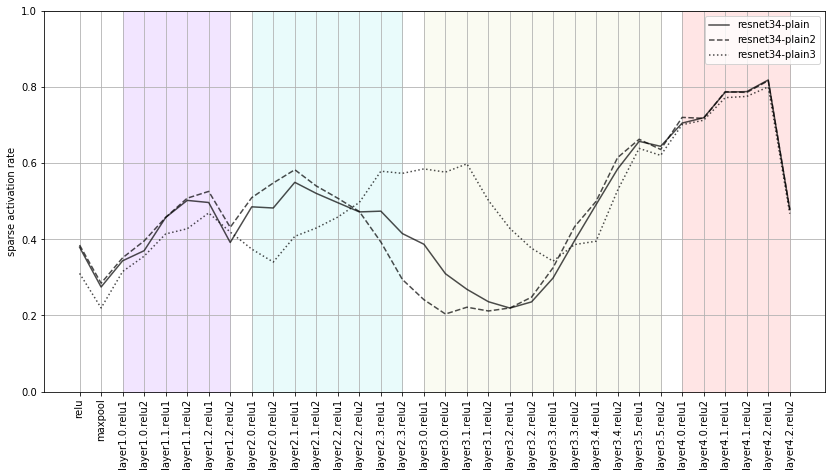

skip


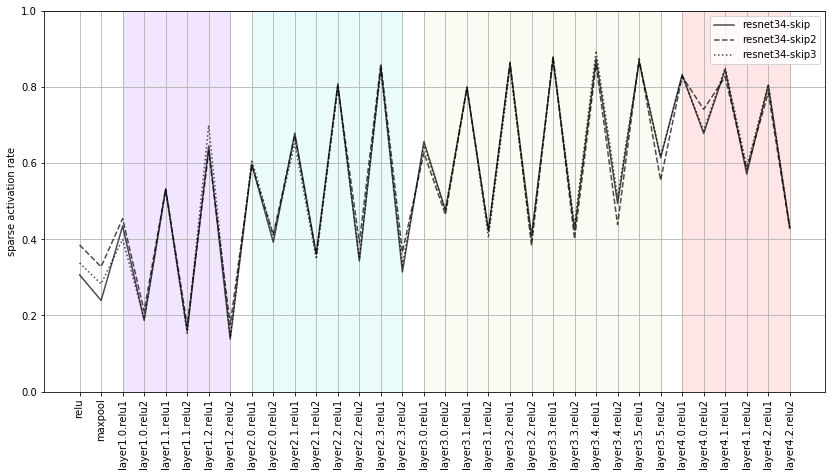

In [60]:
print("plain")
plot_helper(plain_datas, labels=packs[1], fillx=fill_index)
print("skip")
plot_helper(skip_datas, labels=packs[0], fillx=fill_index)

In [34]:
index = np.asarray([i for i, cl in enumerate(cand_layers) if "relu2" in cl])

In [67]:
fill_sepkeys = [
    "layer1",
    "layer2",
    "layer3",
    "layer4"
]
fill_index = []
for key in fill_sepkeys:
    tmp = []
    for i, cl in enumerate(np.asarray(cand_layers)[index]):
        if key in cl:
            tmp.append(i)
    fill_index.append(np.asarray(tmp))

plain


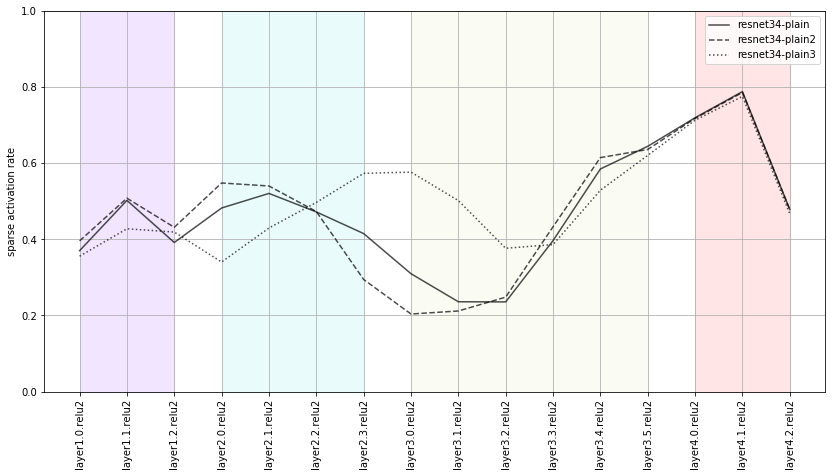

skip


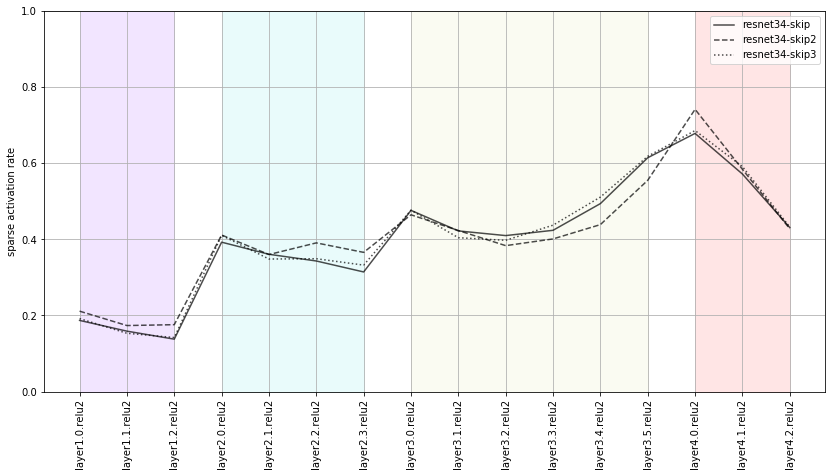

In [68]:
print("plain")
plot_helper(plain_datas, index=index, labels=packs[1], fillx=fill_index)
print("skip")
plot_helper(skip_datas, index=index, labels=packs[0], fillx=fill_index)

In [70]:
index = []
for i in range(1000):
    idx = np.where(test_labels == i)[0]
    index.append(idx[0])
    index.append(idx[1])
    index.append(idx[2])
index = np.asarray(index)

device = "cuda"
N = 256
np.random.seed(815)
perm = np.random.permutation(len(index))
# images = [test_dataset[i][0] for i in index[perm[:N]]]
# images = torch.stack(images)
# images = images.to(device)

In [97]:
packs = [
    ("resnet34-skip", "resnet34-skip2", "resnet34-skip3",),
    ("resnet34-plain", "resnet34-plain2", "resnet34-plain3",)
]

data_list = []

for names in packs:
    datas = []
    for name in tqdm(names, total=len(names)):
        model = get_model(name)
        model = model.eval()
        model = model.to(device)
        tracker = TensorTracker(model, candidate_layers=cand_layers)
        tmp = []
        totals = []
        for i in range(0, len(index), N):
            _images = torch.stack([test_dataset[k][0] for k in index[perm[i:i + N]]])
            _images = _images.to(device)
            with torch.no_grad():
                out = model(_images)
            data = []
#             func = np.frompyfunc(lambda x: (len(x) - np.count_nonzero(x)), 1, 1)
            func = lambda x: (len(x) - np.count_nonzero(x))
            total = []
            for l1 in keys[target_key]:
                act1 = tracker.find_fmap(l1).to('cpu').numpy()
                data.append(func(act1.reshape(-1)))
                total.append(len(act1.reshape(-1)))
            totals.append(total)
            data = np.asarray(data)
            tmp.append(data)
        tracker.remove()
        datas.append(tmp)
    datas = np.asarray(datas)
    data_list.append(datas)

100%|██████████| 3/3 [02:31<00:00, 50.42s/it]


In [98]:
act1.shape

(184, 512, 7, 7)

In [99]:
len(target_key)

34

In [100]:
data_list[0][0].shape

(12, 34)

In [103]:
len(totals)

12

In [105]:
totals = np.asarray(totals)

In [107]:
totals.sum(0)

array([2408448000,  602112000,  602112000,  602112000,  602112000,
        602112000,  602112000,  602112000,  301056000,  301056000,
        301056000,  301056000,  301056000,  301056000,  301056000,
        301056000,  150528000,  150528000,  150528000,  150528000,
        150528000,  150528000,  150528000,  150528000,  150528000,
        150528000,  150528000,  150528000,   75264000,   75264000,
         75264000,   75264000,   75264000,   75264000])

In [108]:
data_list[0][0].sum(0) / totals.sum(0)

array([0.30562074, 0.23887359, 0.43558273, 0.18594219, 0.52995582,
       0.15761488, 0.64694921, 0.13707964, 0.59750893, 0.39158423,
       0.67883418, 0.36220372, 0.80900064, 0.34435821, 0.85274321,
       0.31473444, 0.65724223, 0.47728924, 0.80001615, 0.42266528,
       0.86131012, 0.41107977, 0.87241782, 0.42320608, 0.87541641,
       0.49205646, 0.86799035, 0.61277138, 0.83332389, 0.67806271,
       0.84686078, 0.57065796, 0.80388528, 0.4297517 ])

In [111]:
hoge = np.asarray(data_list)

In [115]:
skip_datas = (hoge[0].sum(axis=1) / totals.sum(0))
plain_datas = (hoge[1].sum(axis=1) / totals.sum(0))

In [117]:
fill_sepkeys = [
    "layer1",
    "layer2",
    "layer3",
    "layer4"
]
# fill_index = np.asarray([i for i, cl in enumerate(cand_layers) if "relu2" in cl])
fill_index = []
for key in fill_sepkeys:
    tmp = []
    for i, cl in enumerate(cand_layers):
        if key in cl:
            tmp.append(i)
    fill_index.append(np.asarray(tmp))

plain


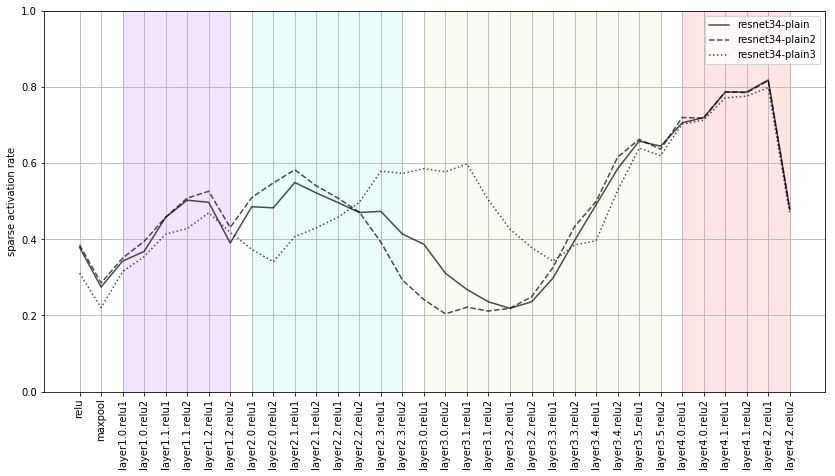

skip


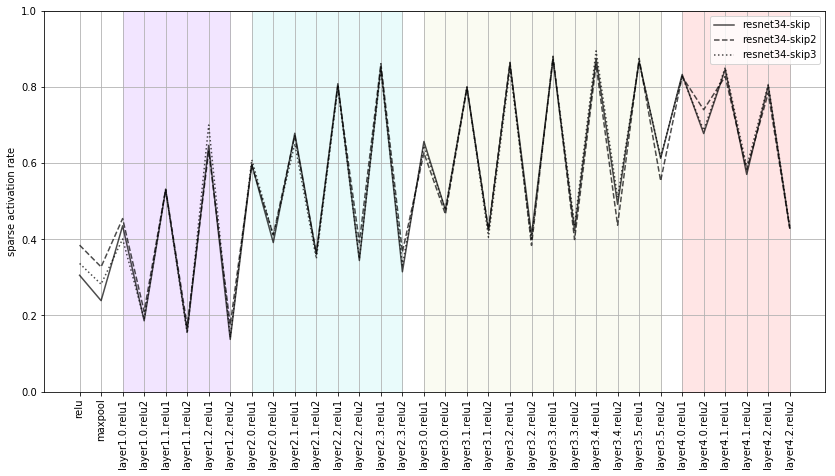

In [118]:
print("plain")
plot_helper(plain_datas, labels=packs[1], fillx=fill_index)
print("skip")
plot_helper(skip_datas, labels=packs[0], fillx=fill_index)

In [119]:
index = np.asarray([i for i, cl in enumerate(cand_layers) if "relu2" in cl])

In [120]:
fill_sepkeys = [
    "layer1",
    "layer2",
    "layer3",
    "layer4"
]
fill_index = []
for key in fill_sepkeys:
    tmp = []
    for i, cl in enumerate(np.asarray(cand_layers)[index]):
        if key in cl:
            tmp.append(i)
    fill_index.append(np.asarray(tmp))

plain


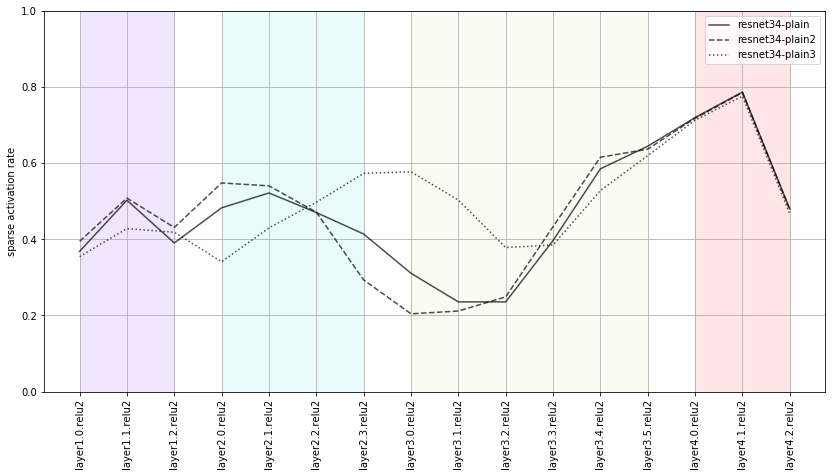

skip


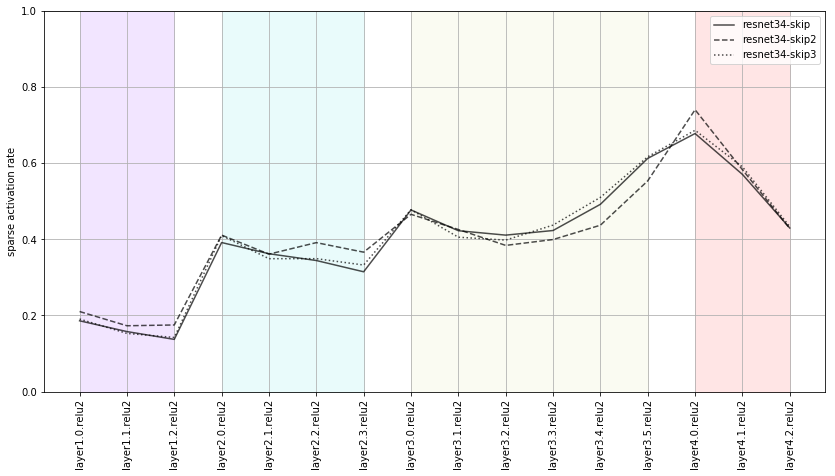

In [121]:
print("plain")
plot_helper(plain_datas, index=index, labels=packs[1], fillx=fill_index)
print("skip")
plot_helper(skip_datas, index=index, labels=packs[0], fillx=fill_index)

In [33]:
model = plain_model
paths = plain_paths[::10]
tracker = p_tracker

packs = [
    (plain_model, p_tracker, plain_paths[-1:]),
    (skip_model, s_tracker, skip_paths[-1:]),
]

# func = lambda x: (len(x) - np.count_nonzero(x)) / len(x)
func = None
data_list = []

for model, tracker, paths in packs:
    datas = []
    for path in tqdm(paths, total=len(paths)):
        name = os.path.basename(path)
        model.load_state_dict(my_resnet.fix_model_state_dict(torch.load(path)))
        model = model.eval()
        model = model.to(device)

        with torch.no_grad():
            out = model(images)
        data = []
        for l1 in keys[target_key]:
            act1 = tracker.find_fmap(l1).to('cpu').numpy()
            if func is not None:
                data.append(func(act1.reshape(-1)))
            else:
                data.append(act1)
        datas.append(data)
    data_list.append(datas)

100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


In [37]:
len(data_list[0][0])

17

In [36]:
data_list[0][0][0].shape

(256, 64, 56, 56)

In [40]:
plain_datas = data_list[0].copy()
skip_datas = data_list[1].copy()

In [46]:
[ print(d.shape) for d in plain_datas[0]]

(256, 64, 56, 56)
(256, 64, 56, 56)
(256, 64, 56, 56)
(256, 64, 56, 56)
(256, 128, 28, 28)
(256, 128, 28, 28)
(256, 128, 28, 28)
(256, 128, 28, 28)
(256, 256, 14, 14)
(256, 256, 14, 14)
(256, 256, 14, 14)
(256, 256, 14, 14)
(256, 256, 14, 14)
(256, 256, 14, 14)
(256, 512, 7, 7)
(256, 512, 7, 7)
(256, 512, 7, 7)


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [48]:
plain_datas[0][-1].shape

(256, 512, 7, 7)

# focus on the channel

In [49]:
data = plain_datas[0][-1]

In [70]:
len(plain_datas[0][-2:])

2

In [76]:
list(range(-3, 0))

[-3, -2, -1]

In [85]:
sort_index.shape

(256, 512)